In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as tt

from utils import load_data, print_config, set_random_seed, CreateDataLoader, draw_cf_matrix, cal_confusion_matrix, f1_score
import config

from Classifier import Classifier
from Generator import Generator
from GANSSL import GANSSL, Discriminator

In [2]:
print_config()

RANDOM_SEED   :  11042004
DATA_DIR      :    ./data
USED_DATA     :    EMNIST
NUM_LABELLED  :        -1
DEVICE        :    cuda:0
GAN_BATCH_SIZE:       128


In [3]:
set_random_seed(config.RANDOM_SEED)

Setting seeds ...... 



In [4]:
if config.USED_DATA == "CIFAR10":
	mean = [0.5]*3
	std = [0.5]*3
	train_tfm = tt.Compose([
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

else:
# if config.USED_DATA == "MNIST" or config.USED_DATA == "DOODLE":
	mean = [0.5]
	std = [0.5]
	train_tfm = tt.Compose([
		tt.Resize(32),
		tt.Normalize(mean, std, inplace=True)
	])

test_tfm = tt.Compose([
	tt.Resize(32),
	tt.Normalize(mean, std)
])

In [5]:
train_ds, test_ds, classes = load_data(train_tfm, test_tfm)

In [6]:
n_classes = len(classes)
channels = train_ds.x.shape[1]
n_classes, channels

(26, 1)

In [7]:
test_dl = CreateDataLoader(test_ds, batch_size=512, device=config.DEVICE)

### ACCURACY

In [8]:
N_Labelled = [50, 100, 500, 'full']
if config.USED_DATA == 'EMNIST':
	N_Labelled = [100, 200, 1000, 'full']
res = {}
for n in N_Labelled:
	res[n] = []
	name = "CNN"


	PATH = f'{config.USED_DATA}/{name}/_{n}'
	
	model = Classifier(channels, n_classes).to(config.DEVICE, non_blocking=True)
	model.load(PATH + ".pt")
	res[n].append(model.evaluate(test_dl))

	name = "GANSSL"

	PATH = f'{config.USED_DATA}/{name}/_{n}'

	if n != 'full':
		model = GANSSL(Generator(100, channels), Discriminator(channels, n_classes), 100, config.DEVICE)
		model.load_dis_state_dict(PATH + ".pt")
		res[n].append(model.evaluate(test_dl))

In [9]:
for n, r in res.items():
	print(f'{n}: {r}')

### HEAT MAP

array([0.19434629, 0.224476  , 0.39575972, 0.24513619, 0.26834611,
       0.26260388, 0.17519271, 0.31209363, 0.48689655, 0.28530873,
       0.33825503, 0.26300149, 0.46329527, 0.3030303 , 0.36606546,
       0.28333333, 0.2020202 , 0.37966932, 0.50732279, 0.34961832,
       0.21401274, 0.41247834, 0.3565664 , 0.36049601, 0.39069767,
       0.45711123])

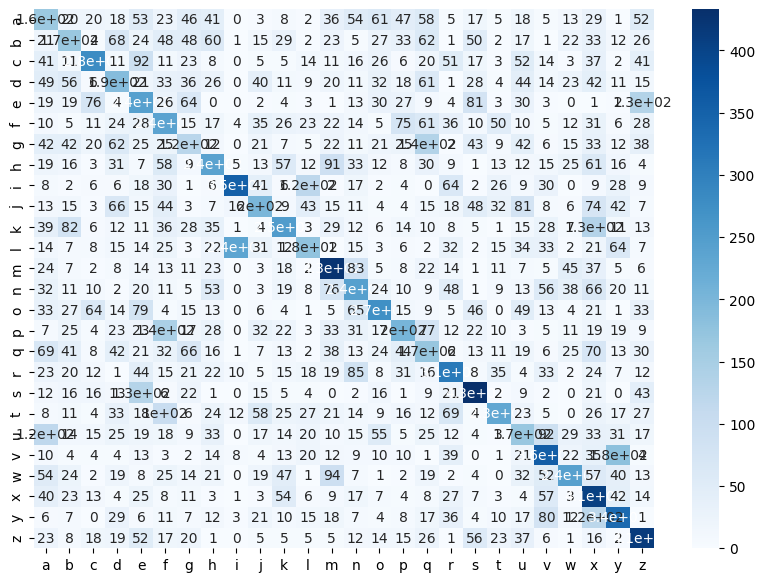

: 

In [12]:
name = "GANSSL"
n = 100

PATH = f'{config.USED_DATA}/{name}/_{n}'

model = GANSSL(Generator(100, channels), Discriminator(channels, n_classes), 100, config.DEVICE)
model.load_dis_state_dict(PATH + ".pt")

cf_matrix = cal_confusion_matrix(model, test_dl, n_classes)

draw_cf_matrix(cf_matrix, classes)

f1_score(cf_matrix)